In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
# Usar el enlace directo al archivo CSV
url = 'https://observer.globe.gov/documents/19589576/60147054/2017_GLOBE-AnnualCloudData_2024-05-02_v3.2.csv'
df = pd.read_csv(url)
df.head()

/var/folders/gt/42270hds6sl65vrszxzb4bbh0000gn/T/ipykernel_9262/101473198.py:3: DtypeWarning: Columns (51,52,53,54,55,56,87,90,91,113,116,117) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url)


,Observation Id,Is GLOBE Trained,is Citizen Science,Site ID,Observation Latitude,Observation Longitude,Observation Elevation,Measurement Date (UTC),Measurement Time (UTC),Sky Color,...,Aqua High Cloud Altitude,Aqua High Cloud Opt,Aqua High Cloud Cover,Aqua High Cloud Phase,Aqua High Cloud Temp (K),Aqua Sat Vzen,Aqua Sat Szen,Aqua Wind,Aqua Snow,Aqua Ocean
116-6172-3151011-201701010000,1,0,6172,45.831118,17.392660,119.0,2017-01-01,00:00:00,blue,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109-45479-19945870-201701010000,1,0,45479,25.380350,49.566630,133.0,2017-01-01,00:00:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150-12924-3438354-201701010000,1,0,12924,26.227000,43.577000,639.0,2017-01-01,00:00:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150-35089-14575255-201701010000,1,0,35089,25.245069,45.257046,737.0,2017-01-01,00:00:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103-33549-8158391-201701010000,1,0,33549,24.772156,46.824337,579.0,2017-01-01,00:00:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df['Surface Air Temperature'].describe()

count    51394.000000
mean       978.068677
std         74.867244
min        484.000000
25%        978.000000
50%       1004.000000
75%       1015.000000
max       1614.000000
Name: Surface Air Temperature, dtype: float64

In [4]:
# El índice solo es el día
# Combinar las columnas y convertir a datetime
df['Measurement DateTime (UTC)'] = pd.to_datetime(
    df['Measurement Date (UTC)'].astype(str) + ' ' + df['Measurement Time (UTC)'].astype(str),
    format='%d/%m/%Y %H:%M:%S'
)

# Extraer solo la fecha
df['Measurement Date (UTC)'] = df['Measurement DateTime (UTC)'].dt.date

# Establecer la columna de fecha como índice
df.set_index('Measurement Date (UTC)', inplace=True)

# Ver las primeras filas
df.head()


,Observation Id,Is GLOBE Trained,is Citizen Science,Site ID,Observation Latitude,Observation Longitude,Observation Elevation,Measurement Time (UTC),Sky Color,Sky Visibility,...,Aqua High Cloud Opt,Aqua High Cloud Cover,Aqua High Cloud Phase,Aqua High Cloud Temp (K),Aqua Sat Vzen,Aqua Sat Szen,Aqua Wind,Aqua Snow,Aqua Ocean,Measurement DateTime (UTC)
Measurement Date (UTC),,,,,,,,,,,,,,,,,,,,,
2017-01-01,116-6172-3151011-201701010000,1,0,6172,45.831118,17.392660,119.0,00:00:00,blue,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-01
2017-01-01,109-45479-19945870-201701010000,1,0,45479,25.380350,49.566630,133.0,00:00:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-01
2017-01-01,150-12924-3438354-201701010000,1,0,12924,26.227000,43.577000,639.0,00:00:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-01
2017-01-01,150-35089-14575255-201701010000,1,0,35089,25.245069,45.257046,737.0,00:00:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-01
2017-01-01,103-33549-8158391-201701010000,1,0,33549,24.772156,46.824337,579.0,00:00:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-01


In [5]:
# Función para gráficar las series de tiempo junto con la evaluación del modelo

def plot_exponential_smoothing(series, method="SES", alpha=0.3, trend=None, seasonal=None, seasonal_periods=None, forecast_periods=10, titulo=None):
    """
    Graficar series temporales utilizando suavización exponencial (SES, Holt o Holt-Winters) y evaluar el modelo.

    Parameters:
        - series: Serie temporal (pandas Series).
        - method: Método a usar ("SES" para SimpleExpSmoothing, "Holt" para Holt, "Holt-Winters" para ExponentialSmoothing).
        - alpha: Nivel de suavización (0 < alpha <= 1, solo para SES o Holt).
        - trend: Tipo de tendencia ("add" o "mul", solo para Holt o Holt-Winters).
        - seasonal: Tipo de estacionalidad ("add" o "mul", solo para Holt-Winters).
        - seasonal_periods: Número de períodos estacionales (requerido para Holt-Winters).
        - forecast_periods: Número de períodos a pronosticar.
        - titulo: Título para la gráfica.
    """
    # Verificar si la serie tiene frecuencia definida
    if series.index.freq is None:
        raise ValueError("La serie no tiene frecuencia definida. Asigna una frecuencia antes de usar este método.")

    # Rellenar valores faltantes, si es necesario
    if series.isnull().any():
        print("Advertencia: La serie contiene valores faltantes. Se rellenarán usando 'ffill'.")
        series = series.ffill()

    # Ajustar el modelo según el método seleccionado
    if method == "SES":  # Simple Exponential Smoothing
        model = SimpleExpSmoothing(series).fit(smoothing_level=alpha, optimized=False)
    elif method == "Holt":  # Holt's Linear Trend Model
        model = Holt(series, exponential=False, damped_trend=False).fit(smoothing_level=alpha, smoothing_trend=alpha, optimized=False)
    elif method == "Holt-Winters":  # Exponential Smoothing (Holt-Winters)
        if seasonal_periods is None:
            raise ValueError("Debes especificar 'seasonal_periods' para el método Holt-Winters.")
        model = ExponentialSmoothing(series, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).fit()
    else:
        raise ValueError("El parámetro 'method' debe ser 'SES', 'Holt', o 'Holt-Winters'.")

    # Fitted values (valores ajustados) y pronóstico
    fitted_values = model.fittedvalues
    forecast = model.forecast(forecast_periods)

    # Evaluar el modelo
    mae = mean_absolute_error(series, fitted_values)
    mse = mean_squared_error(series, fitted_values)
    rmse = np.sqrt(mse)

    # Imprimir las métricas de evaluación
    print(f"Evaluación del modelo - {method} para {titulo}:")
    print(f"MAE  (Error Absoluto Medio): {mae:.4f}")
    print(f"MSE  (Error Cuadrático Medio): {mse:.4f}")
    print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse:.4f}")

    # Gráfica
    plt.figure(figsize=(12, 6))
    plt.plot(series, label="Serie original", color="blue")
    plt.plot(fitted_values, label="Valores ajustados", linestyle="--", color="orange")
    plt.plot(forecast, label=f"Pronóstico ({forecast_periods} períodos)", linestyle=":", color="green")
    plt.title(f"{titulo} - {method}" if titulo else f"Suavización Exponencial - {method}", fontsize=16)
    plt.xlabel("Índice", fontsize=12)
    plt.ylabel("Valores", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()


Serie de tiempo de Surface Air Temperature para un tipo de nube Baja (Stratus)

In [6]:
#Conservamos solo las observaciones para Stratus y para una latitud determinada
df_Stratus = df[(df['Stratus'] == 1) &
                (df['Observation Latitude'] >= 15) &
                (df['Observation Latitude'] <= 32)]

In [7]:
# Eliminamos los valores nulos
df_Stratus_T = df_Stratus['Surface Air Temperature'].dropna()
df_Stratus_T.head()

,Surface Air Temperature
Measurement Date (UTC),
2017-01-01,28.0
2017-01-02,17.0
2017-01-02,28.0
2017-01-02,11.0
2017-01-02,11.0


In [8]:
# Eliminar duplicados del índice de df_Stratus_T
df_Stratus_T = df_Stratus_T[~df_Stratus_T.index.duplicated(keep='first')]

# Ajustar la frecuencia a diaria
df_Stratus_T = df_Stratus_T.asfreq('D')  # Seleccionar solo los puntos de datos con frecuencia diaria

# Manejar valores faltantes (usando el método directo ffill)
df_Stratus_T = df_Stratus_T.ffill()  # Rellenar valores faltantes hacia adelante

# Ver las primeras filas del DataFrame ajustado
df_Stratus_T.head()

,Surface Air Temperature
Measurement Date (UTC),
2017-01-01,28.0
2017-01-02,17.0
2017-01-03,21.0
2017-01-04,23.0
2017-01-05,27.0


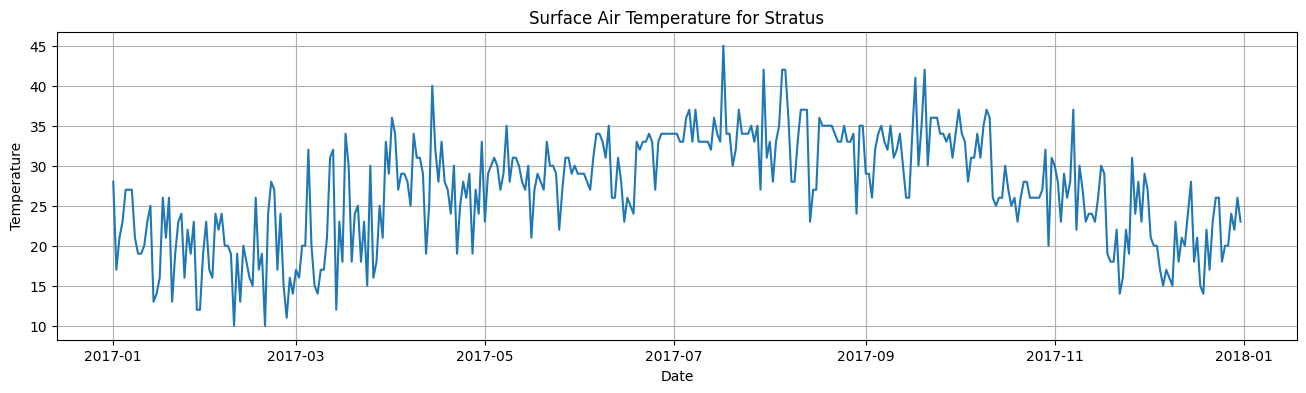

In [9]:
plt.figure(figsize=(16,4))
plt.plot(df_Stratus_T)
plt.title('Surface Air Temperature for Stratus')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.grid()
plt.show()

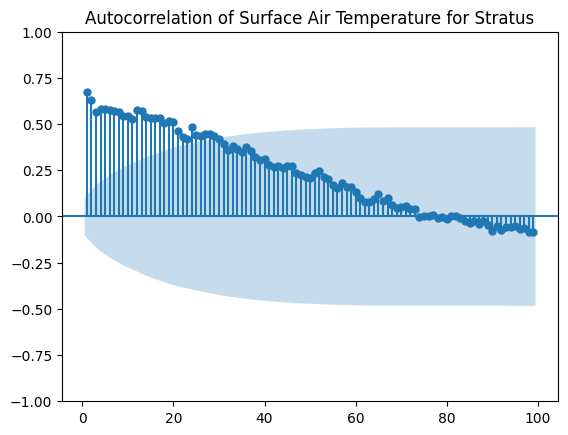

In [10]:
# Autocorrelation Function (acf)
from statsmodels.graphics.tsaplots import plot_acf
fig = plot_acf(df_Stratus_T, lags=range(1,100), alpha=0.05)
plt.title('Autocorrelation of Surface Air Temperature for Stratus')
plt.show()

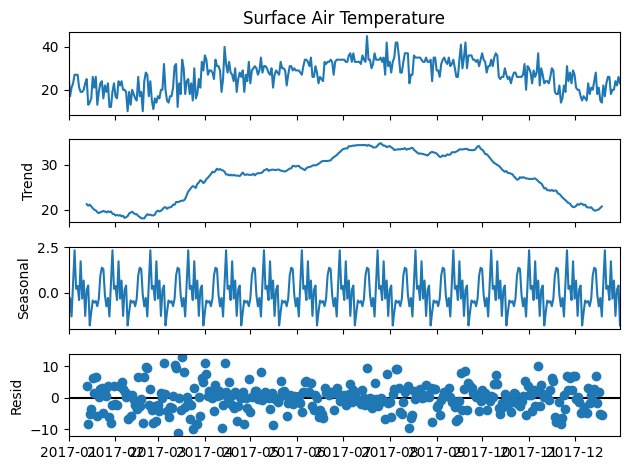

In [11]:
decomposition = seasonal_decompose(df_Stratus_T, model='additive', period=25)
decomposition.plot()
plt.show()

Evaluación del modelo - Holt-Winters para Surface Air Temperature for Stratus:
MAE  (Error Absoluto Medio): 3.1154
MSE  (Error Cuadrático Medio): 15.6010
RMSE (Raíz del Error Cuadrático Medio): 3.9498


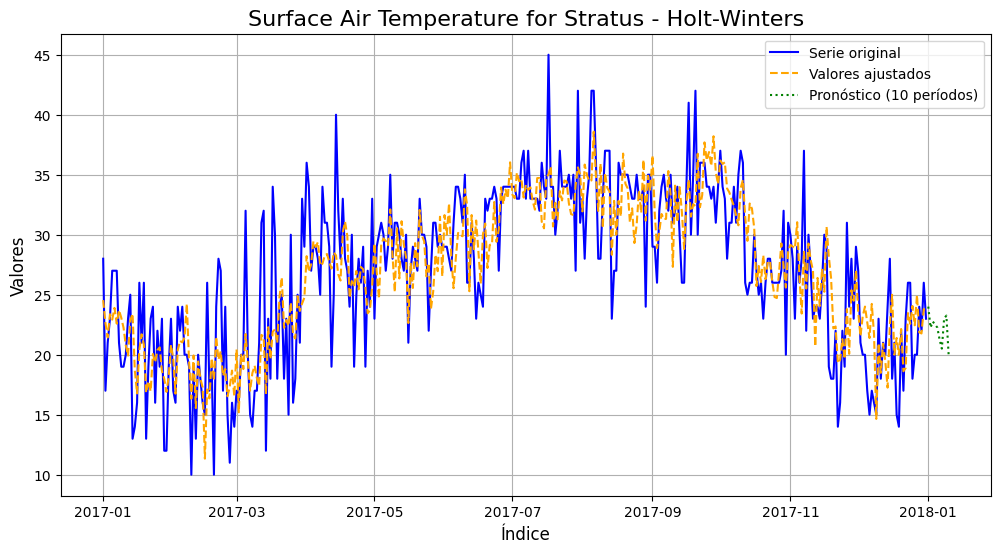

In [12]:
plot_exponential_smoothing(df_Stratus_T, method="Holt-Winters", alpha=0.5, seasonal_periods=90, trend=None, seasonal='add', forecast_periods=10, titulo= 'Surface Air Temperature for Stratus')

Serie de tiempo de Surface Air Temperature para un tipo de nube Alta

In [13]:
df_Cirrus = df[(df['Cirrus'] == 1) & (df['Observation Latitude'] >= 15) & (df['Observation Latitude'] <= 32)]

In [14]:
df_Cirrus_T = df_Cirrus['Surface Air Temperature'].dropna()
df_Cirrus_T.head()

,Surface Air Temperature
Measurement Date (UTC),
2017-01-01,22.0
2017-01-01,37.0
2017-01-01,26.0
2017-01-01,32.0
2017-01-01,30.0


In [15]:
# Eliminar duplicados del índice de df_Stratus_T
df_Cirrus_T = df_Cirrus_T[~df_Cirrus_T.index.duplicated(keep='first')]

# Ajustar la frecuencia a diaria
df_Cirrus_T = df_Cirrus_T.asfreq('D')  # Seleccionar solo los puntos de datos con frecuencia diaria

# Manejar valores faltantes (usando el método directo ffill)
df_Cirrus_T = df_Cirrus_T.ffill()  # Rellenar valores faltantes hacia adelante

# Ver las primeras filas del DataFrame ajustado
df_Cirrus_T.head()

,Surface Air Temperature
Measurement Date (UTC),
2017-01-01,22.0
2017-01-02,22.0
2017-01-03,24.0
2017-01-04,28.0
2017-01-05,23.0


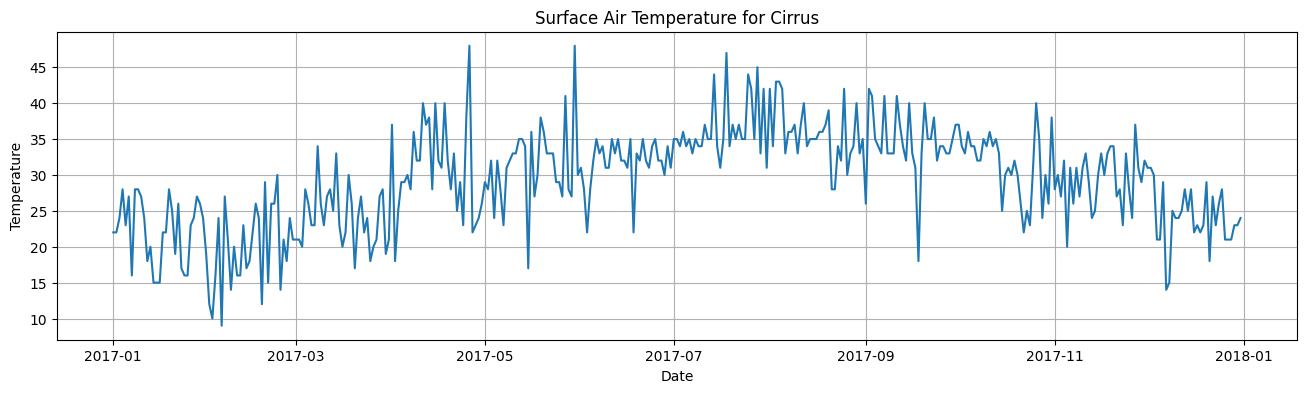

In [16]:
# Hace una gráfica de la serie
plt.figure(figsize=(16,4))
plt.plot(df_Cirrus_T)
plt.title('Surface Air Temperature for Cirrus')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.grid()
plt.show()

Text(0.5, 1.0, 'Autocorrelation of Surface Air Temperature for Cirrus')

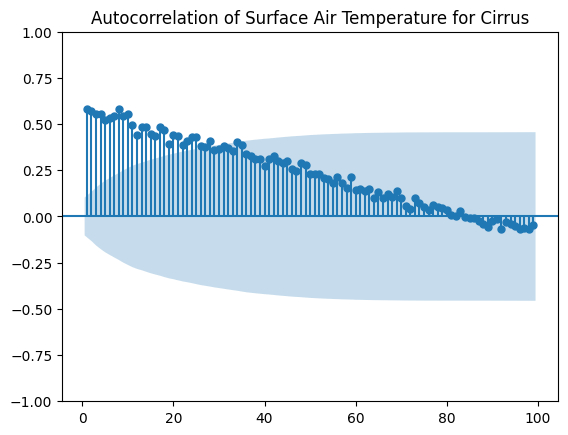

In [17]:
 fig = plot_acf(df_Cirrus_T, lags=range(1,100), alpha=0.05)
 plt.title('Autocorrelation of Surface Air Temperature for Cirrus')

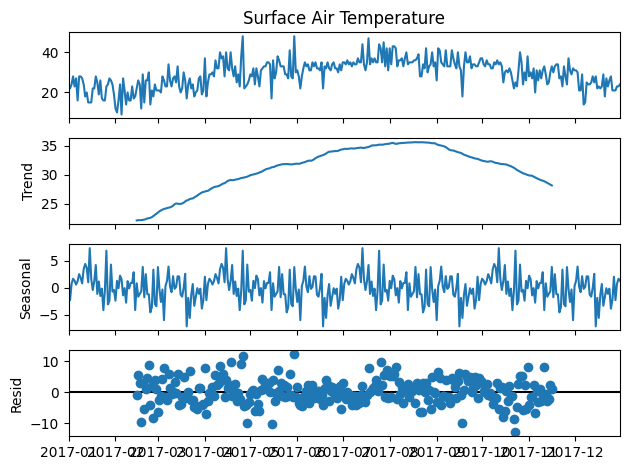

In [18]:
decomposition = seasonal_decompose(df_Cirrus_T, model='additive', period=90)
decomposition.plot()
plt.show()

Evaluación del modelo - Holt-Winters para Surface Air Temperature for Cirrus:
MAE  (Error Absoluto Medio): 3.4310
MSE  (Error Cuadrático Medio): 18.7363
RMSE (Raíz del Error Cuadrático Medio): 4.3285


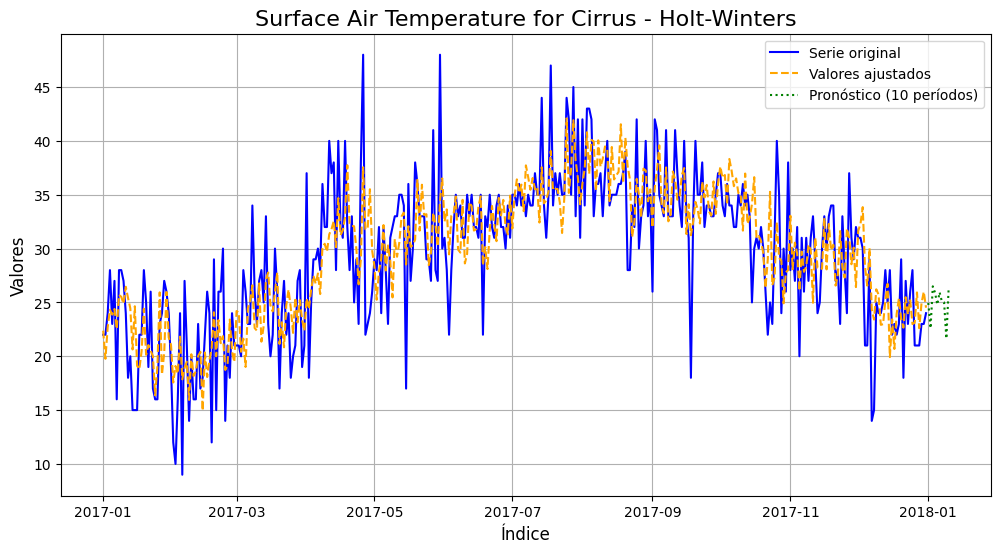

In [19]:
plot_exponential_smoothing(df_Cirrus_T, method="Holt-Winters", alpha=0.5, seasonal_periods=90, trend="add", seasonal="add", forecast_periods=10, titulo= 'Surface Air Temperature for Cirrus')

Serie de tiempo de Surface Air Temperature para un tipo de nube Media

In [20]:
df_Altocumulus = df[(df['Altocumulus'] == 1) & (df['Observation Latitude'] >= 15) & (df['Observation Latitude'] <= 32)]

In [21]:
df_Altocumulus_T = df_Altocumulus['Surface Air Temperature'].dropna()
df_Altocumulus_T.head()

,Surface Air Temperature
Measurement Date (UTC),
2017-01-01,23.0
2017-01-01,16.0
2017-01-02,29.0
2017-01-02,19.0
2017-01-03,25.0


In [22]:
# Eliminar los duplicados
df_Altocumulus_T = df_Altocumulus_T[~df_Altocumulus_T.index.duplicated(keep='first')]

# Establecer la frecuencia diaria
df_Altocumulus_T = df_Altocumulus_T.asfreq('D')

# Manejar valores faltantes (usando el método directo ffill)
df_Altocumulus_T = df_Altocumulus_T.ffill()
df_Altocumulus_T.head()

,Surface Air Temperature
Measurement Date (UTC),
2017-01-01,23.0
2017-01-02,29.0
2017-01-03,25.0
2017-01-04,29.0
2017-01-05,24.0


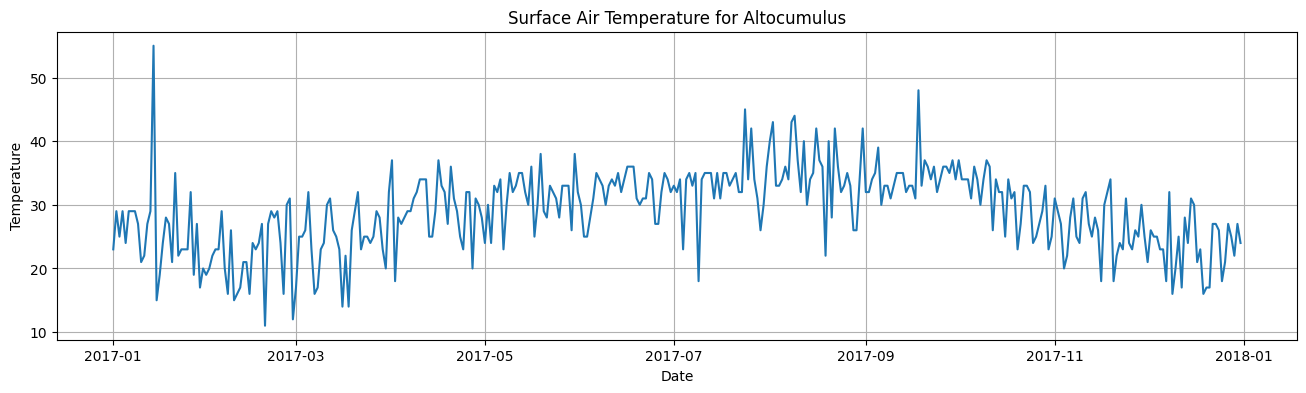

In [23]:
# Hacer una gráfica de la serie
plt.figure(figsize=(16,4))
plt.plot(df_Altocumulus_T)
plt.title('Surface Air Temperature for Altocumulus')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.grid()
plt.show()

Text(0.5, 1.0, 'Autocorrelation of Surface Air Temperature for Cirrus')

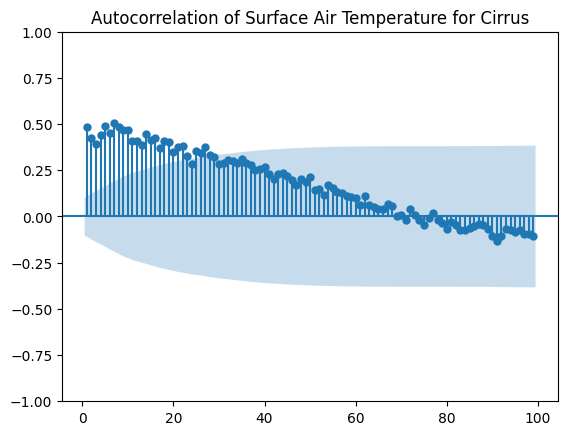

In [24]:
 # Autocorrelación
 fig = plot_acf(df_Altocumulus_T, lags=range(1,100), alpha=0.05)
 plt.title('Autocorrelation of Surface Air Temperature for Cirrus')

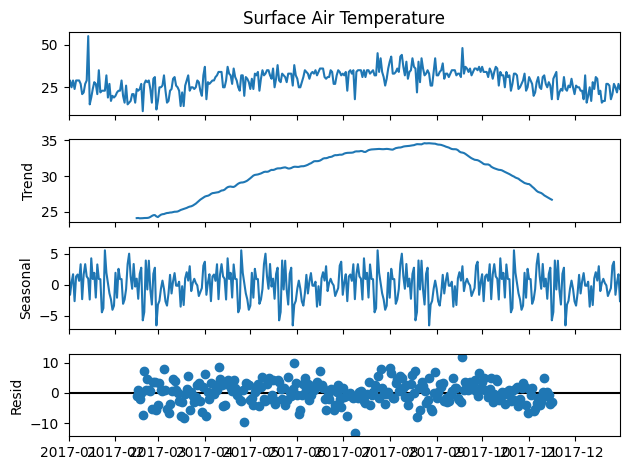

In [25]:
decomposition = seasonal_decompose(df_Altocumulus_T, model='additive', period=90)
decomposition.plot()
plt.show()

Evaluación del modelo - Holt-Winters para Surface Air Temperature for Altocumulus:
MAE  (Error Absoluto Medio): 3.2591
MSE  (Error Cuadrático Medio): 17.6646
RMSE (Raíz del Error Cuadrático Medio): 4.2029


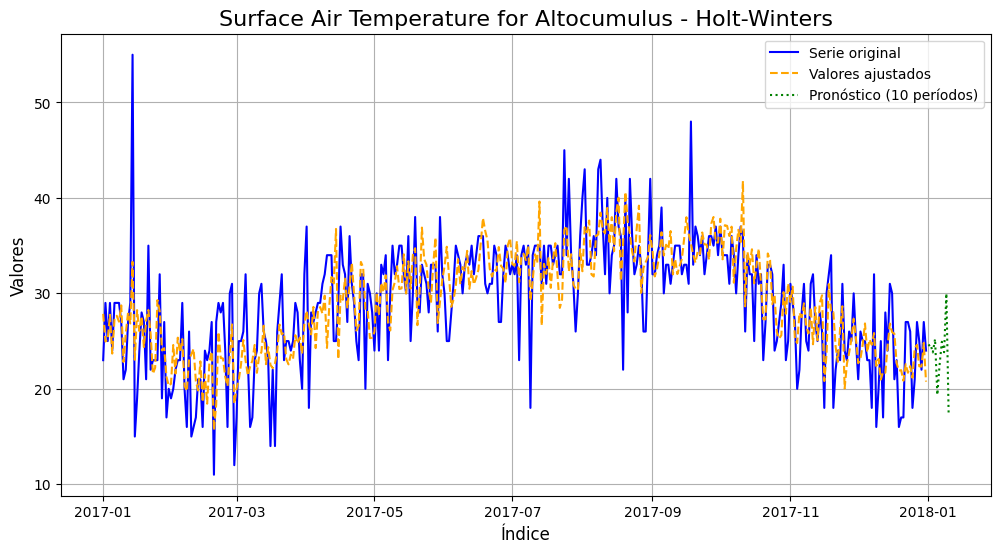

In [26]:
plot_exponential_smoothing(df_Altocumulus_T, method="Holt-Winters", alpha=0.5, seasonal_periods=90, trend="add", seasonal="add", forecast_periods=10, titulo= 'Surface Air Temperature for Altocumulus')